In [1]:
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os

## Goal: Generate survival curves for patient level data for genes

Steps

survival analysis as specified in this project plan https://docs.google.com/document/d/1m4oHf4mL8xrwRjJbfZEe02NuO8qJH8iIC7nJ9f8qKpY/edit

## Outputs
* survival plots for each gene for 4 different groups (90/90), (90/10), (75/75). (75/25)
* dataframe/csv of log rank p values for all genes and all groups

In [2]:
gene_list_csv = '../data/110920_new drug list v1.csv'
gene_list_name = 'novel'
cohort = 'tcga'
suffix = 'v1'

In [3]:
plot_dir = 'outputs/survival_plots_{}_{}_{}'.format(gene_list_name,cohort,suffix)

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [4]:
genes_to_keep = pd.read_csv(gene_list_csv, header = None)
genes_to_keep = list(genes_to_keep[0])

In [5]:
gene_file = 'bulkky.csv'
survival_file = 'survival.csv'
data_dir = '../data'

In [6]:
df_gene = pd.read_csv(os.path.join(data_dir,gene_file),index_col = False)
df_survival = pd.read_csv(os.path.join(data_dir,survival_file))
df_gene.head()

,Unnamed: 0,tcga-2j-aab1-0,tcga-2j-aab4-0,tcga-2j-aab8-0,tcga-2j-aabe-0,tcga-2j-aabh-0,tcga-2j-aabk-0,tcga-2j-aabo-0,tcga-2j-aabp-0,tcga-2j-aabt-0,...,PCSI_0048-2,PCSI_0460-2,PCSI_0301-2,PCSI_0074-2,PCSI_0230-2,PCSI_0593-2,PCSI_0642-2,PCSI_0173-2,PCSI_0162-2,PCSI_0638-2
0,FGFR2,3.321870,3.555205,3.198075,3.325090,2.157619,3.410962,2.305467,1.593193,3.818382,...,3.956832,2.718442,3.091814,4.486808,3.855023,3.941427,3.361588,2.241948,2.462543,2.503070
1,SFT2D3,2.554821,2.141104,2.694381,2.594298,2.328804,2.309437,2.635775,2.550215,2.098051,...,0.010256,0.037203,0.056899,0.073533,0.016807,0.065275,0.027492,0.000000,2.385753,0.000000
2,CLEC2L,0.114166,0.268167,0.126541,0.264928,0.360577,0.251321,0.977498,1.972221,0.367716,...,0.000000,0.000000,0.111527,0.000000,0.000000,0.000000,0.000000,0.268521,0.000000,0.000000
3,PCYT2,3.828386,3.381373,3.316260,3.402833,3.877422,3.139071,3.676570,3.099575,3.483028,...,2.406003,2.808628,3.102525,3.961894,4.001701,4.375243,3.841514,4.545875,4.427328,3.890691
4,ZNF630,1.163930,1.074284,1.195381,1.124767,0.919313,1.013129,1.142824,0.650426,1.040603,...,1.290594,0.558158,1.885497,1.949062,2.095290,0.675230,1.306497,0.647626,0.784424,1.808027


In [7]:
df_gene = df_gene.rename({'Unnamed: 0':'Gene'},axis = 1)
df_gene = df_gene.set_index(keys = ['Gene'])

In [8]:
df_gene_transposed = df_gene.T
df_gene_transposed.reset_index(inplace = True)
df_gene_transposed.rename({'index':'ID'}, inplace=True, axis = 1)

In [9]:
genes_to_keep = [gene for gene in genes_to_keep if gene in df_gene_transposed.columns]

In [10]:
df_gene_transposed = df_gene_transposed[['ID'] +genes_to_keep]

## Visualize distribution of genes

In [11]:
df_gene_transposed.head()

Gene,ID,ATAD3B,PRKCZ,UBR4,SLC9A1,MACF1,EPS15,NRAS,NOTCH2,FCGR2A,...,SIRPA,PLCG1,ATP9A,BACE2,PI4KA,MAPK1,MIF,SH3KBP1,SLC38A5,DLG3
0,tcga-2j-aab1-0,2.642570,3.604736,4.635304,4.261014,4.595309,3.098141,2.835355,2.986148,3.432299,...,3.374451,2.976651,3.459549,4.858403,3.651217,3.499341,6.818243,3.475439,2.361202,3.760625
1,tcga-2j-aab4-0,3.092772,3.181805,4.988428,4.375531,4.693069,3.210578,3.073919,3.348145,3.747426,...,3.474806,3.067024,3.739935,5.266391,3.662740,3.663166,6.929102,3.608474,3.221211,3.539930
2,tcga-2j-aab8-0,3.234812,2.925668,4.734746,3.688178,4.720298,3.174535,3.226687,2.935306,3.655164,...,3.287806,3.220829,3.134464,5.347512,3.347169,3.506251,6.104793,3.635631,3.624561,2.815282
3,tcga-2j-aabe-0,3.355081,3.600884,4.959557,3.873224,4.782633,3.118874,2.561105,2.722642,4.097535,...,3.692657,3.264250,3.864433,5.318800,3.712409,3.574449,7.059535,3.316770,2.526888,3.550881
4,tcga-2j-aabh-0,2.564573,2.789457,4.502605,3.789249,4.100178,2.613847,2.512002,2.958980,3.530925,...,2.906434,2.795244,3.262002,5.074019,3.216269,3.225809,6.353464,3.360223,4.005018,3.431367


In [12]:
#plt.figure(figsize = (30,15))
#sns.heatmap(df_gene_transposed.drop(['ID'],axis = 1),cmap="YlGnBu")

In [13]:
df_gene_transposed.shape

(308, 126)

In [14]:
gene_column_list = [col for col in list(df_gene_transposed.columns) if 'ID' not in col]

In [15]:
df_survival.shape

(309, 5)

In [16]:
df_survival.head()

,pid,OS,OS_status,PFS,PFS_status
0,tcga-2j-aab1-0,2.169839,1.0,2.169839,0.0
1,tcga-2j-aab4-0,23.966861,0.0,23.966861,0.0
2,tcga-2j-aab8-0,2.630108,0.0,2.630108,0.0
3,tcga-2j-aabe-0,22.224414,0.0,22.224414,0.0
4,tcga-2j-aabk-0,15.912154,0.0,15.912154,0.0


## merge datasets

In [17]:
df_joined = pd.merge(df_gene_transposed, df_survival, left_on = ['ID'], right_on = ['pid'], how = 'inner')

In [18]:
df_joined.shape

(307, 131)

In [19]:
if cohort != 'all':
    df_joined['ID'] = df_joined['ID'].str.lower()
    df_joined = df_joined[df_joined['ID'].str.contains(cohort)]

In [20]:
df_joined.shape

(139, 131)

## visualize missing data

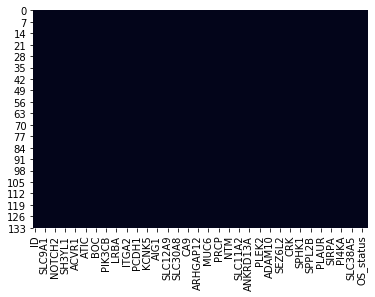

In [21]:
sns.heatmap(df_joined.isnull(), cbar = False)

In [22]:
percentile_list = [
    (50,50),
    (25, 75),
    (10, 90),
    (75, 75),
    (90, 90)
]

gene_list = []
high_list = []
low_list = []
p_list = []
count_high_list = []
count_low_list = []
value_high_list = []
value_low_list = []
longer_survival_list = []
longer_survival_filtered_list = []

for idx, gene in enumerate(gene_column_list):
    

        df_gene = df_joined[[gene,'OS', 'OS_status']]

        for percentile_low, percentile_high in percentile_list:

            value_high = np.percentile(df_gene[gene], percentile_high)
            value_low = np.percentile(df_gene[gene], percentile_low)

            df_high = df_gene[df_gene[gene] > value_high]
            df_low = df_gene[df_gene[gene] <= value_low]
            
            mean_high = df_high['OS'].mean()
            mean_low = df_low['OS'].mean()

            if mean_high > mean_low:
                longer_survival = 'above'
            else:
                longer_survival = 'below'
                
            mean_high_filtered = df_high[df_high['OS_status'] == 1]['OS'].mean()
            mean_low_filtered = df_low[df_low['OS_status'] == 1]['OS'].mean()
            
            if mean_high_filtered > mean_low_filtered:
                longer_survival_filtered = 'above'
            else:
                longer_survival_filtered = 'below'            

            duration_high = df_high['OS']
            duration_low = df_low['OS']

            observed_high = df_high['OS_status'].astype(int)
            observed_low = df_low['OS_status'].astype(int)

            res = logrank_test(duration_high,duration_low, observed_high, observed_low)
            p_value = res.p_value

            gene_list.append(gene)
            high_list.append(percentile_high)
            low_list.append(percentile_low)
            p_list.append(p_value)
            count_high_list.append(df_high.shape[0])
            count_low_list.append(df_low.shape[0])
            value_high_list.append(value_high)
            value_low_list.append(value_low)
            longer_survival_list.append(longer_survival)
            longer_survival_filtered_list.append(longer_survival_filtered)
            if p_value < .05:
                plt.figure()
                ax = plt.subplot(111)
                kmf = KaplanMeierFitter()
                kmf.fit(duration_high, observed_high, label="Above {:.0f} percentile".format(percentile_high))
                ax = kmf.plot(ax=ax)

                kmf.fit(duration_low, observed_low,label="Below {:.0f} percentile".format(percentile_low))
                ax = kmf.plot(ax=ax)

                ax.set_title("Kaplan Meier Curve - {}".format(gene));
                ax.set_ylabel('survival')
                plt.savefig('outputs/survival_plots_{}_{}_{}/{}_{}_high_{}_low.png'.format(gene_list_name,
                                                                                        cohort,
                                                                                        suffix,
                                                                                        gene,
                                                                                        percentile_high,
                                                                                        percentile_low))
                plt.close()

            print('done with {}/{}'.format(idx+1, len(gene_column_list)))

done with 1/125
done with 1/125
done with 1/125
done with 1/125
done with 1/125
done with 2/125
done with 2/125
done with 2/125
done with 2/125
done with 2/125
done with 3/125
done with 3/125
done with 3/125
done with 3/125
done with 3/125
done with 4/125
done with 4/125
done with 4/125
done with 4/125
done with 4/125
done with 5/125
done with 5/125
done with 5/125
done with 5/125
done with 5/125
done with 6/125
done with 6/125
done with 6/125
done with 6/125
done with 6/125
done with 7/125
done with 7/125
done with 7/125
done with 7/125
done with 7/125
done with 8/125
done with 8/125
done with 8/125
done with 8/125
done with 8/125
done with 9/125
done with 9/125
done with 9/125
done with 9/125
done with 9/125
done with 10/125
done with 10/125
done with 10/125
done with 10/125
done with 10/125
done with 11/125
done with 11/125
done with 11/125
done with 11/125
done with 11/125
done with 12/125
done with 12/125
done with 12/125
done with 12/125
done with 12/125
done with 13/125
done wit

In [23]:
output_df = pd.DataFrame(
{'gene': gene_list,
'above_percentile': high_list,
'below_percentile':low_list,
'p_value': np.round(p_list,4),
'count_above': count_high_list,
'count_below': count_low_list,
'above_percentile_value': np.round(value_high_list,4),
'below_percentile_value': np.round(value_low_list,4),
'longer_survival':longer_survival_list,
'longer_survival_filtered':longer_survival_filtered_list,

}
)

In [24]:
output_df.to_csv('outputs/logrank_results_{}_{}_{}.csv'.format(gene_list_name,cohort,suffix),index=False)